Step1: Implement DQN using relaxed Bellman while designing PBCN system for learning¶
First we design the environment variables using the knowledge of PBCN parameters, dynamics and rewarding scheme. For other Markovian process that can be extracted from standard libraries like "gym" this step can be omitted.

Once the system is designed and the dynamics computed, we provide template for caculating attractors using "networkx" package, in turn seggregating desired and undesired attractors. For the current work, it was calculated beforehand and used in the code.

Next, we implement DQN for PBCN stabilization and provide plots for better visualization and interpretation at the end.

0.49 % complete.
1.02 % complete.
1.54 % complete.
2.07 % complete.
2.6 % complete.
3.12 % complete.
3.65 % complete.
4.17 % complete.
4.7 % complete.
5.22 % complete.
5.75 % complete.
6.27 % complete.
6.8 % complete.
7.33 % complete.
7.85 % complete.
8.38 % complete.
8.9 % complete.
9.43 % complete.
9.95 % complete.
10.48 % complete.
11.01 % complete.
11.53 % complete.
12.06 % complete.
12.58 % complete.
13.11 % complete.
13.63 % complete.
14.16 % complete.
14.68 % complete.
15.21 % complete.
15.74 % complete.
16.26 % complete.
16.79 % complete.
17.31 % complete.
17.84 % complete.
18.36 % complete.
18.89 % complete.
19.42 % complete.
19.94 % complete.
20.47 % complete.
20.99 % complete.
21.52 % complete.
22.04 % complete.
22.57 % complete.
23.09 % complete.
23.62 % complete.
24.15 % complete.
24.67 % complete.
25.2 % complete.
25.72 % complete.
26.25 % complete.
26.77 % complete.
27.3 % complete.
27.83 % complete.
28.35 % complete.
28.88 % complete.
29.4 % complete.
29.93 % complete.


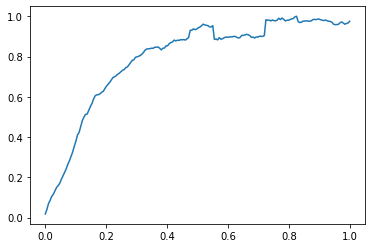

In [5]:
# Import libraries required for PBCN problem
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import pylab as plt
# import networkx as nx
import numpy as np
import time
import sys

# ---------------------->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Creating PBCN Parameters <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<----------------------------

ns = 9 # Number of State variables
nc = 2 # Number of Control variables
n = ns + nc # Total variables

# Generate table of all possible binary combinations between states-action pairs
table = list(itertools.product([0, 1], repeat=n))

# function to convert boolean to decimal values
def bool2dec(table_name,n_val,table_len,flag):
  dec_value=np.zeros(table_len)
  for i in range(0,table_len):
    for j in range(0,n_val):
      if flag==0:                              # flag defines if control u is taken into consideration or not
        dec_value[i]=(np.power(2,(n_val-j-1)))*table_name[i][j+nc]+dec_value[i] # for u at the beginning
      else:
        dec_value[i]=(np.power(2,(n_val-j-1)))*table_name[i][j]+dec_value[i] # for u at the beginning
  return dec_value

value=bool2dec(table,ns,len(table),0)
df=pd.DataFrame([table[0:len(table)],value])      # Dataframe comprising of state-action pairs and corresponding decimal values

no_of_perm = 4                                    # no of possible permutations in reference to states possessing sub network structure
no_of_vars_with_diff_paths = 2                    # no of variables possesing sub networks
f = np.zeros([ns+int(no_of_perm/no_of_vars_with_diff_paths),df.shape[1]])

# Boolean dynamics of the system given by x_{k+1} = f_{x_{k},u_{k}}
for i in range(0,df.shape[1]):
  f[0,i]=(1-df[i][0][8]) and df[i][0][4]
  f[1,i]=df[i][0][2]
  f[2,i]=(1-df[i][0][0])
  f[3,i]=df[i][0][6] and df[i][0][7]
  f[4,i]=(1-df[i][0][0]) and df[i][0][3] and df[i][0][1]
  f[5,i]=df[i][0][6]
  f[6,i]=df[i][0][2]
  f[7,i]=(1-df[i][0][5]) and (1-df[i][0][9])
  f[8,i]=df[i][0][5] or df[i][0][6] or df[i][0][10]
  f[9,i]=(1-df[i][0][0]) and (df[i][0][6] or df[i][0][1])
  f[10,i]=df[i][0][10]

# creating and storing dataframes for individual sub networks
dummy_df=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[4,:],f[6,:],f[7,:],f[8,:],f[9,:]])
df2=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[4,:],f[6,:],f[7,:],f[8,:],f[9,:],bool2dec(dummy_df,ns,df.shape[1],1)])
dummy_df=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[5,:],f[6,:],f[7,:],f[8,:],f[9,:]])
df3=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[5,:],f[6,:],f[7,:],f[8,:],f[9,:],bool2dec(dummy_df,ns,df.shape[1],1)])
dummy_df=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[4,:],f[6,:],f[7,:],f[8,:],f[10,:]])
df4=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[4,:],f[6,:],f[7,:],f[8,:],f[10,:],bool2dec(dummy_df,ns,df.shape[1],1)])
dummy_df=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[5,:],f[6,:],f[7,:],f[8,:],f[10,:]])
df5=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[5,:],f[6,:],f[7,:],f[8,:],f[10,:],bool2dec(dummy_df,ns,df.shape[1],1)])

# probabilities associated with corresponding paths
pc = np.ones(f.shape[0])
pc[0]=1.0
pc[1]=1.0
pc[2]=1.0
pc[3]=1.0
pc[4]=0.7
pc[5]=0.3
pc[6]=1.0
pc[7]=1.0
pc[8]=1.0
pc[9]=0.6
pc[10]=0.4


points_list_U1=list()           # transitions in decimal form with control u = 00
points_list_U2=list()           # transitions in decimal form with control u = 01
points_list_U3=list()           # transitions in decimal form with control u = 10
points_list_U4=list()           # transitions in decimal form with control u = 11
edge_weights_U1={}              # probabilities of transitions with control u = 00
edge_weights_U2={}              # probabilities of transitions with control u = 01
edge_weights_U3={}              # probabilities of transitions with control u = 10
edge_weights_U4={}              # probabilities of transitions with control u = 11

# notations indicating control chosen
control_dict={0:"u1=0,u2=0",
             1:"u1=0,u2=1",
             2:"u1=1,u2=0",
             3:"u1=1,u2=1",
            -1:"No Control"}

c = np.power(2,ns)
for i in range(np.power(2,ns)):                             # transitions are calculated in reference to the underlying dynamical equations and corresponding probabilities are stored
  points_list_U1.append((df[i].iloc[-1],df2[i].iloc[-1]))
  edge_weights_U1[points_list_U1[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U1.append((df[i].iloc[-1],df3[i].iloc[-1]))
  if points_list_U1[-1] in points_list_U1[0:len(points_list_U1)-1]:
    edge_weights_U1[points_list_U1[-1]]=str(float(edge_weights_U1[points_list_U1[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  else:
    edge_weights_U1[points_list_U1[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U1.append((df[i].iloc[-1],df4[i].iloc[-1]))
  if points_list_U1[-1] in points_list_U1[0:len(points_list_U1)-1]:
    edge_weights_U1[points_list_U1[-1]]=str(float(edge_weights_U1[points_list_U1[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U1[points_list_U1[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  points_list_U1.append((df[i].iloc[-1],df5[i].iloc[-1]))
  if points_list_U1[-1] in points_list_U1[0:len(points_list_U1)-1]:
    edge_weights_U1[points_list_U1[-1]]=str(float(edge_weights_U1[points_list_U1[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U1[points_list_U1[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))

  points_list_U2.append((df[i+c].iloc[-1],df2[i+c].iloc[-1]))
  edge_weights_U2[points_list_U2[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U2.append((df[i+c].iloc[-1],df3[i+c].iloc[-1]))
  if points_list_U2[-1] in points_list_U2[0:len(points_list_U2)-1]:
    edge_weights_U2[points_list_U2[-1]]=str(float(edge_weights_U2[points_list_U2[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  else:
    edge_weights_U2[points_list_U2[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U2.append((df[i+c].iloc[-1],df4[i+c].iloc[-1]))
  if points_list_U2[-1] in points_list_U2[0:len(points_list_U2)-1]:
    edge_weights_U2[points_list_U2[-1]]=str(float(edge_weights_U2[points_list_U2[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U2[points_list_U2[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  points_list_U2.append((df[i+c].iloc[-1],df5[i+c].iloc[-1]))
  if points_list_U2[-1] in points_list_U2[0:len(points_list_U2)-1]:
    edge_weights_U2[points_list_U2[-1]]=str(float(edge_weights_U2[points_list_U2[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U2[points_list_U2[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))

  points_list_U3.append((df[i+2*c].iloc[-1],df2[i+2*c].iloc[-1]))
  edge_weights_U3[points_list_U3[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U3.append((df[i+2*c].iloc[-1],df3[i+2*c].iloc[-1]))
  if points_list_U3[-1] in points_list_U3[0:len(points_list_U3)-1]:
    edge_weights_U3[points_list_U3[-1]]=str(float(edge_weights_U3[points_list_U3[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  else:
    edge_weights_U3[points_list_U3[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U3.append((df[i+2*c].iloc[-1],df4[i+2*c].iloc[-1]))
  if points_list_U3[-1] in points_list_U3[0:len(points_list_U3)-1]:
    edge_weights_U3[points_list_U3[-1]]=str(float(edge_weights_U3[points_list_U3[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U3[points_list_U3[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  points_list_U3.append((df[i+2*c].iloc[-1],df5[i+2*c].iloc[-1]))
  if points_list_U3[-1] in points_list_U3[0:len(points_list_U3)-1]:
    edge_weights_U3[points_list_U3[-1]]=str(float(edge_weights_U3[points_list_U3[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U3[points_list_U3[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))  
  
  points_list_U4.append((df[i+3*c].iloc[-1],df2[i+3*c].iloc[-1]))
  edge_weights_U4[points_list_U4[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U4.append((df[i+3*c].iloc[-1],df3[i+3*c].iloc[-1]))
  if points_list_U4[-1] in points_list_U4[0:len(points_list_U4)-1]:
    edge_weights_U4[points_list_U4[-1]]=str(float(edge_weights_U4[points_list_U4[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  else:
    edge_weights_U4[points_list_U4[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U4.append((df[i+3*c].iloc[-1],df4[i+3*c].iloc[-1]))
  if points_list_U4[-1] in points_list_U4[0:len(points_list_U4)-1]:
    edge_weights_U4[points_list_U4[-1]]=str(float(edge_weights_U4[points_list_U4[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U4[points_list_U4[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  points_list_U4.append((df[i+3*c].iloc[-1],df5[i+3*c].iloc[-1]))
  if points_list_U4[-1] in points_list_U4[0:len(points_list_U4)-1]:
    edge_weights_U4[points_list_U4[-1]]=str(float(edge_weights_U4[points_list_U4[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U4[points_list_U4[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))

# function to calculate possible attractors of the given PBCN
def find_Attractors(G,nx):
  number_of_attractor = nx.number_attracting_components(G)
  a_list = list(nx.attracting_components(G))
  return a_list

# Template for calculating attractors for stabilization objectives.

# Visualizing the graphs for u1 = 0, u2 = 0
# print("Graph with combination U1=0;U2=0")
# GU1=nx.DiGraph()
# GU1.add_edges_from(points_list_U1)
# posU1=nx.circular_layout(GU1)
# nx.draw_networkx_nodes(GU1,posU1,node_size=500)
# nx.draw_networkx_edges(GU1,posU1,arrowstyle='-|>',arrowsize=20,arrows=True)
# nx.draw_networkx_labels(GU1,posU1)
# nx.draw_networkx_edge_labels(GU1,posU1,edge_labels=edge_weights_U1)
# # plt.show()

# # Calculating and saving attractors for individual control actions
# attractor_set = []
# a_calc = find_Attractors(GU1,nx)
# attractor_set.append(a_calc)

# Visualizing the graphs for u1 = 0, u2 = 1
# print("Graph with combination U1=0;U2=1")
# GU2=nx.DiGraph()
# GU2.add_edges_from(points_list_U2)
# posU2=nx.circular_layout(GU2)
# nx.draw_networkx_nodes(GU2,posU2,node_size=500)
# nx.draw_networkx_edges(GU2,posU2,arrowstyle='-|>',arrowsize=20,arrows=True)
# nx.draw_networkx_labels(GU2,posU2)
# nx.draw_networkx_edge_labels(GU2,posU2,edge_labels=edge_weights_U2)
# plt.show()

# a_calc = find_Attractors(GU2,nx)
# if a_calc not in attractor_set:
#   attractor_set.append(a_calc)

# Visualizing the graphs for u1 = 1, u2 = 0
# print("Graph with combination U1=1;U2=0")
# GU3=nx.DiGraph()
# GU3.add_edges_from(points_list_U3)
# posU3=nx.circular_layout(GU3)
# nx.draw_networkx_nodes(GU3,posU3,node_size=500)
# nx.draw_networkx_edges(GU3,posU3,arrowstyle='-|>',arrowsize=20,arrows=True)
# nx.draw_networkx_labels(GU3,posU3)
# nx.draw_networkx_edge_labels(GU3,posU3,edge_labels=edge_weights_U3)
# plt.show()

# a_calc = find_Attractors(GU3,nx)
# if a_calc not in attractor_set:
#   attractor_set.append(a_calc)

# Visualizing the graphs for u1 = 1, u2 = 1
# print("Graph with combination U1=1;U2=1")
# GU4=nx.DiGraph()
# GU4.add_edges_from(points_list_U4)
# posU4=nx.circular_layout(GU4)
# nx.draw_networkx_nodes(GU4,posU4,node_size=500)
# nx.draw_networkx_edges(GU4,posU4,arrowstyle='-|>',arrowsize=20,arrows=True)
# nx.draw_networkx_labels(GU4,posU4)
# nx.draw_networkx_edge_labels(GU4,posU4,edge_labels=edge_weights_U4)
# plt.show()

# a_calc = find_Attractors(GU4,nx)
# if a_calc not in attractor_set:
#   attractor_set.append(a_calc)



# Creating probability transition matrices for existent sub networks.
probs_U1=np.zeros([np.power(2,ns),np.power(2,ns)])
probs_U2=np.zeros([np.power(2,ns),np.power(2,ns)])
probs_U3=np.zeros([np.power(2,ns),np.power(2,ns)])
probs_U4=np.zeros([np.power(2,ns),np.power(2,ns)])
for i in range(len(points_list_U1)):
  probs_U1[int(points_list_U1[i][0])][int(points_list_U1[i][1])]=edge_weights_U1[points_list_U1[i]]
  probs_U2[int(points_list_U2[i][0])][int(points_list_U2[i][1])]=edge_weights_U2[points_list_U2[i]]
  probs_U3[int(points_list_U3[i][0])][int(points_list_U3[i][1])]=edge_weights_U3[points_list_U3[i]]
  probs_U4[int(points_list_U4[i][0])][int(points_list_U4[i][1])]=edge_weights_U4[points_list_U4[i]]

# ---------------------->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Creating PBCN Parameters <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<----------------------------

# ---------------------->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Defining and implementing RL control <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<----------------------------

# Model-free Reinforcement Learning

# Define parameters required for Q-learning

num_nodes=np.power(2,ns)
initial_state=np.random.choice(range(num_nodes-1))
initial_dim=0
goal=507                                          # desired attractor: decimal-507
undesired_goals=[4,68]                            # undesired attractors: decimal - 4, 68
gamma=0.8                                         # discount factor: \gamma \in [0,1)
lr=0.8                                            # learning rate: \alpha \in (0,1]

# Environment variables
PTM=np.stack((edge_weights_U1,edge_weights_U2,edge_weights_U3,edge_weights_U4))     # Defining probability transitions matrix for training phase
PTM2=np.stack((probs_U1,probs_U2,probs_U3,probs_U4))                                # Defining probability transitions matrix for testing phase
proportional_factor = 1.0                                                           # Proportionality factor for creating rewards

# Model-free Controller using Q-learning
Q=np.zeros([np.power(2,ns),np.power(2,nc)]) # Initialize Q table to zeros with dimensions defined by states-action pairs

Q_algo=[]     # Initialize a dummy Q as a placeholder in greedy algo for DQN
def greedy_policy(state,model_buff):
  data_buff=np.array([state_key[state]])
  data_regr=np.squeeze(model_buff.predict(data_buff))                  # Use the DQN model for predicting Q-values
  action_prob = np.ones(np.power(2,nc))*EPSILON/np.power(2,nc)         # define action probabilities as \epsilon/|A(s)|
  # choose best action to be a*=\underset{a\in A(s)}{\arg \max} Q
  best_action=np.squeeze(np.where(data_regr==np.max(data_regr)))
  if best_action.size>1:
    best_action = np.random.choice(best_action,size=1)
  action_prob[best_action]+=(1-EPSILON)                                # for a* set action probability = \epsilon/|A(s)| + (1-\epsilon)
  
  return action_prob

# Calc rewards on the basis of current state, and next state calculated through a greedy action.
def calc_reward(current_state,next_state,action):
  reward_buff=[]
  if next_state == goal:
    reward_buff = 1*float(PTM[action][current_state,next_state])
  elif next_state in undesired_goals:
    reward_buff = -1*float(PTM[action][current_state,next_state])
  else:
    reward_buff = 1*float(PTM[action][current_state,next_state])

  return float(reward_buff)

# Calc next_state on the basis of current state, and a greedy action for function approximator learning.
def calc_next_state(current_state,action):
  next_state_buff=[]
  reward_buff=[]
  for key1, key2 in PTM[action]:   # iter on both keys and values
    reward_buff_c=0
    if key1==current_state:
      next_state_buff.append(key2)
      reward_buff.append(PTM[action][key1,key2])
      reward_buff_c+=float(reward_buff[-1])
      if int(reward_buff_c)==1:
        break
  next_state = int(np.random.choice(next_state_buff,size=1))
  reward = calc_reward(current_state,next_state,action)

  return next_state, reward

# Define environment as: [current_state, next_state, action, reward] = env(current_state, Q_algo), where Q_algo is either DQN or QLRF.
def env(current_state,model_buff):
  action_probabilities = greedy_policy(current_state,model_buff)                                  # calculate action probabilities using greedy policy
  action = np.random.choice(np.arange(len(action_probabilities)), p = action_probabilities)       # calculate action
  if action.size > 1:                      # if there are multiple actions choose any one randomly and for the chosen random action, choose single next_state if multiple transitions are possible
    action = int(np.random.choice(action,size=1))
    next_state, reward = calc_next_state(current_state, action)
  else:
    next_state, reward = calc_next_state(current_state, action)

  return np.array([current_state,next_state,action,reward])

n=ns+nc

# Function to create a model for KerasRegressor with hidden layer as per the number of datapoints to be inspected, activated using 'linear' activations function and minimising SGD MSE.
def create_model():
    # Create a model
    model = Sequential()
    model.add(Dense(n*n, input_dim=ns, activation='linear'))
    model.add(Dense(n*n, activation='linear'))
    model.add(Dense(n*n, activation='linear'))
    model.add(Dense(np.power(2,nc), activation='linear'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='SGD', metrics=['mse'])
    return model

# set a seed for rehearsing the results
seed = 0
np.random.seed(seed)

# initialise target model with random weights
target_model=create_model()

# DQN algorithm
def dQn(RANDOM_TRANSITIONS_DATA_buff):

  Q_pred_dqn = np.zeros(Q.shape)                                     # Initialize Q to zeros

  # generate D=(xn,yn) from state-action-value pairs from replay buffer
  data_buff = np.squeeze(RANDOM_TRANSITIONS_DATA_buff)
  X = np.array([list(item) for item in np.array(data_buff[:,2])])
  y = np.array([item for item in data_buff[:,3]])

  # Standardized the data for good predictions
  sc = StandardScaler()
  X = sc.fit_transform(X)
  Y = sc.fit_transform(y)

  # Fit the DQN using the data extracted from Experience Replay buffer
  estimator=KerasRegressor(build_fn=create_model, epochs=1, batch_size=4, verbose=0)
  results=estimator.fit(X,Y)
  
  # generate predictions using fitted DNN model and use inverse transform to generate unscaled original values
  target_model.set_weights(results.model.get_weights())     # Save the target model weights from predicting model every step
  y_pred=target_model.predict(X)
  y_pred=sc.inverse_transform(y_pred)

  # remove rewards lower than or higher than a certain threshold in order to avoid bad predictions
  for k in range(y_pred.shape[0]):
    if (y_pred[k,:].all()>REWARD_LB) and (y_pred[k,:].all()<=REWARD_UB):
      Q_pred_dqn[int(data_buff[k,0]),:] = y_pred[k,:]

  return Q_pred_dqn, target_model

# ------------------------>>>>>>>>>>>>>>>>> Training Module <<<<<<<<<<<<<<<<----------------------------
start_time = time.time()                                            # start the timer to time overall code execution for DQN algorithm to train

# Initialize overall normalized score for all the algorithm
scores_DQN = []
# Initialize predict (Q) and target (\hat{Q}) for DQN
Q_target_DQN = np.zeros([np.power(2,ns),np.power(2,nc)])
Q_predict_DQN = np.zeros([np.power(2,ns),np.power(2,nc)])
# Define parameters for exploration-exploitation type learning starting from complete exploration to near exploitation of target Q values.
# Although, it must be noted that, in the current scheme of work epsilon is just a placeholder to calculate the next action being in some state. 
# The idea we make use of, is to compute all the actions being in some state, to pace up the process.
EPSILON = 1.0
EPSILON_DECAY_RATE = 0.95
EPSILON_MIN = 0.05
EPSILON_DECAY_ITER = 8
# set maximum replay buffer capacity or RB_{cap}
REPLAY_BUFFER_MAX = 16
# set number of parameters to be stored in replay buffer; i.e., current_state, next_state, action, reward
no_of_params_RB = 4
# initialize replay buffers for DQN
REPLAY_BUFFER_DQN = np.zeros([REPLAY_BUFFER_MAX,no_of_params_RB])
# set maximum iterations to train and batch size to be sampled
BATCH = 16
MAX_ITER = np.power(2,ns) + int(np.power(2,ns)/REPLAY_BUFFER_MAX) + (REPLAY_BUFFER_MAX-BATCH)*REPLAY_BUFFER_MAX + 2500 # Optimal iterations as number of states + (number of states/RB_{cap}) + extra steps, if required.
# initialize randomly sampled dataset for DQN algorithm
RANDOM_TRANSITIONS_DQN = np.zeros([BATCH,no_of_params_RB])
# define upper and lower bounds on rewards achieved, a very high negative and positive reward is chosen assuming there is no bad data predicted.
REWARD_LB = -1000
REWARD_UB = 1000
# initialize random transitions dataset D_i \in random_transitions dataset D according to defined batch size.
RANDOM_TRANSITIONS_DATA = []
# initialize targets for DQN
TARGET = np.zeros([BATCH,np.power(2,nc)])
# initialize losses for DQN
LOSS = np.zeros([BATCH,1])
# initialize counts and state_key for corresponding states and action boolean values
cnt = 0
idx_cnt = 0
state_key = list(itertools.product([0, 1], repeat=ns))
state_key_c = list(itertools.product([0, 1], repeat=nc))
# initialise data buffer predicted by the models for calculating Q_{max} in each step
Q_target_data_buff=0
Q_target_data_buff_X=0
# Set the relaxation parameter \xi as needed.
xi=1.2

for i in range(MAX_ITER):

  # current_state = np.random.randint(0, num_nodes)
  current_state = i%np.power(2,ns)
  
  # generate replay buffer for DQN learning
  REPLAY_BUFFER_DQN[idx_cnt, :] = env(int(current_state), target_model)

  idx_cnt+=1
  cnt+=1

  # reduce epsilon every training step so as to maintain exploration-exploitation.
  # Although, as mentioned, here it acts just as a placeholder from pervious code and has no role to play.
  if EPSILON >= EPSILON_MIN and cnt%EPSILON_DECAY_ITER==0:
    EPSILON*=EPSILON_DECAY_RATE
  
  # iteratre until replay buffer is completely filled and once the data is available train DQN model
  if cnt%REPLAY_BUFFER_MAX==0 and cnt!=0:
    
    idx = np.random.randint(REPLAY_BUFFER_MAX, size=BATCH)    # choose random indexes of size batch from replay buffer
    # generate random transitions sample dataset for training 
    RANDOM_TRANSITIONS_DQN = REPLAY_BUFFER_DQN[idx, :]

    # for all the values in random transitions dataset train DQN model
    for l in range(BATCH):
      # for DQN we choose exploring all the states at any given state value allowing to fasten the training process
      for k in range(np.power(2,nc)):
        # with current state-action pairs generate target values for learning
        next_state, reward = calc_next_state(int(RANDOM_TRANSITIONS_DQN[l,0]),k)
        
        # if next state == terminal: --> target = maximum reward else: --> target = r+\gamma \underset{a \in A(s)}{\arg \max} Q(s,a)
        if next_state == goal:
          TARGET[l,k] = calc_reward(int(RANDOM_TRANSITIONS_DQN[l,0]),next_state,k)
        else:
          # calculate Q_{max} using the best action being in current state
          Q_target_data_buff_X=np.array([state_key[int(next_state)]])
          Q_target_data_buff=np.squeeze(target_model.predict(Q_target_data_buff_X))
          # max_index=np.squeeze(np.argmax(Q_target_data_buff))
          max_index=np.squeeze(np.where(Q_target_data_buff==np.max(Q_target_data_buff)))

          if max_index.size > 1:
              max_index = int(np.random.choice(max_index, size = 1))
          else:
              max_index = int(max_index)
          max_value = Q_target_data_buff[max_index]

          # target = (r+\gamma \underset{a \in A(s)}{\arg \max} Q(s,a))/\xi - Relaxed Bellman operator
          TARGET[l,k] = (reward+gamma*(max_value))/xi

      # random transitions data comprises of current_state, action , binary key for transitions, target.
      RANDOM_TRANSITIONS_DATA.append(np.array([RANDOM_TRANSITIONS_DQN[l,0],RANDOM_TRANSITIONS_DQN[l,2],state_key[int(RANDOM_TRANSITIONS_DQN[l,0])],TARGET[l,:]]))

    # predict Q values using DQN algorithm and store values for computing MDP score.
    Q_predict_DQN,target_model=dQn(RANDOM_TRANSITIONS_DATA)
    for l in range(Q_predict_DQN.shape[0]):
      for k in range(Q_predict_DQN.shape[1]):
        if Q_predict_DQN[l,k]!=0:                  # update target Q values using newer values in predict Q values and avoid bad predictions
          Q_target_DQN[l,k] = Q_predict_DQN[l,k]

    
    # flush all the data from replay buffer and randomly sampled dataset
    idx_cnt = 0
    REPLAY_BUFFER_DQN = np.zeros([REPLAY_BUFFER_MAX,no_of_params_RB])
    RANDOM_TRANSITIONS_DATA = []

    # calculate normalized rewards or scores
    if (np.max(Q_target_DQN) > 0):
      scores_pred = ((np.sum(Q_target_DQN/np.max(Q_target_DQN)*100)))
    else:
      scores_pred=0
    scores_DQN.append(scores_pred)

    # print overall progress of the training process.
    print(np.round((i/MAX_ITER)*100,2),'% complete.')

# print total time taken for the overall training
print('Total time taken for training of DQN')
print("--- %s seconds ---" % (time.time() - start_time))

# # generate normalized score (and a linear x-space) from successive steps for plotting convergence
t1 = np.linspace(0, 1, len(scores_DQN))
scores = scores_DQN/np.max(scores_DQN)
plt.plot(t1,scores)
plt.show()

# ------------------------>>>>>>>>>>>>>>>>> Training Module <<<<<<<<<<<<<<<<----------------------------

# ---------------------->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Defining and implementing RL control <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<----------------------------


Once the training is done, one can analyse the trained Q values using all the three algorithms and verify its accuracy/optimality in terms of available state transition graphs.

In [6]:
# Generate heat-maps for analysis
crms=np.transpose(Q_target_DQN)                   # Q table to understand the values learnt

np.random.seed(24)
df_dummy = pd.DataFrame({'Q': np.linspace(0, 3, 4)})
df_dummy = pd.concat([df_dummy, pd.DataFrame(crms)],axis=1)

import seaborn as sns

cm = sns.light_palette("blue", as_cmap=True)

s5 = df_dummy.style.background_gradient(cmap=cm)
s5

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


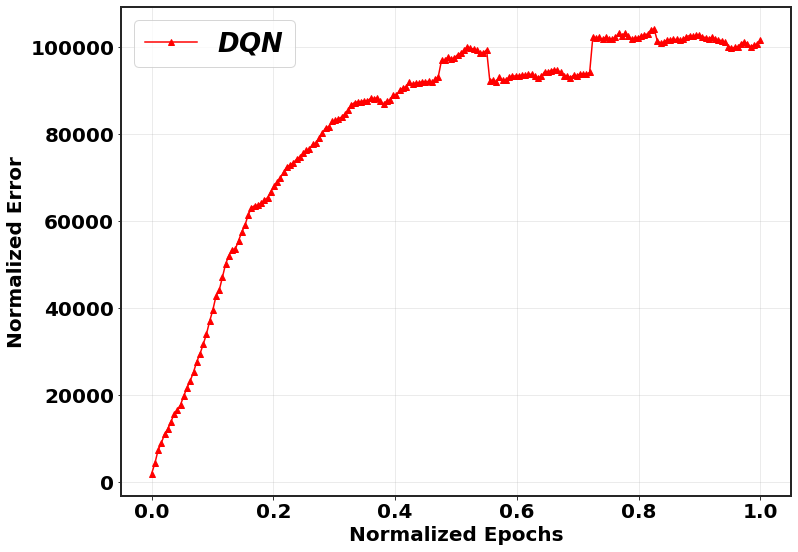

In [7]:
# NOTE: Try to avoid MDP scores starting with negative values; it might lead to erroneous interpretations. 
#       In which case, re-run the training to obtain all positive values.


# Formatting the plots for better visualisation

t1 = np.linspace(0, 1, len(scores_DQN))

plt.rcParams.update({'font.family': 'Times New Roman', 'font.size': 20, 'font.weight': 'bold'})
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 2
fig = plt.figure(figsize=(12, 9))
plt.plot(t1, scores_DQN, label=r'$DQN$', color = 'red', marker='^')

plt.xlabel('Normalized Epochs',fontsize='20', fontweight='bold')
plt.ylabel('Normalized Error',fontsize='20', fontweight='bold')
plt.legend(prop={"size":26})
plt.grid(alpha=0.3)
plt.show()

# fig.savefig('DQN_MDP_plot.png', dpi=300, bbox_inches = "tight")
# np.save('scores_DQN.npy',scores_DQN)

In [14]:
# ------------------------>>>>>>>>>>>>>>>>> Testing Module <<<<<<<<<<<<<<<<----------------------------

# Initialize data for training process
current_state = np.random.randint(0,num_nodes)
initial_state = current_state
steps = [current_state]
steps_actions = []
goal = 507
chance = 0.5                                # Variable used to generate aperiodic behaviour
[current_state,next_state,action,reward] = env(current_state,target_model)
action_flag_log = []
Q_dp = PTM2

while (current_state != goal):                        # Run the episode until the PBCN terminates in the desired attractor

    if np.random.rand() > chance:                     # In order to generate aperiodic behaviour we make use of a random variable to be compare with a chance
        # If random number is greater than chance keep the same action, else update.

        next_state = np.squeeze(np.where(Q_dp[int(action),int(current_state),:]>0))
        if next_state.size>1:
            next_state = int(np.random.choice(np.squeeze(np.where(Q_dp[int(action),int(current_state),:]>0)),size=1))
        else:
            next_state = int(np.squeeze(np.where(Q_dp[int(action),int(current_state),:]>0)))
        action_flag = -1
            
    else:
        action = np.squeeze(np.where(Q_target_DQN[int(current_state),:] == np.max(Q_target_DQN[int(current_state),:])))

        if action.size > 1:
          action = int(np.random.choice(action,size=1))
          next_state = np.squeeze(np.where(Q_dp[int(action),int(current_state),:]>0))
          if next_state.size>1:
            next_state = int(np.random.choice(np.squeeze(np.where(Q_dp[int(action),int(current_state),:]>0)),size=1))
        else:
          next_state = np.squeeze(np.where(Q_dp[int(action),int(current_state),:]>0))
          if next_state.size>1:
            next_state = int(np.random.choice(np.squeeze(np.where(Q_dp[int(action),int(current_state),:]>0)),size=1))
          else:
            next_state = int(np.squeeze(np.where(Q_dp[int(action),int(current_state),:]>0)))
        action_flag = 0
    
    # Update steps taken and corresponding actions.
    steps.append(next_state)
    current_state = next_state

    steps_actions.append(action)
    action_flag_log.append(action_flag)

# Print the steps taken and actions to understand the overall behavior.
print("------------------------->>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<<<--------------------")
print("Applying Q-learning based control")
print("This example starts with ",initial_state," and ends in ",goal)
for i in range(len(steps)-1):
  print("Current Node: ",steps[i])
  if i!=len(steps)-1:
    if action_flag_log[i]==-1:
      print("Current Control Action: ",control_dict[int(action_flag_log[i])])
    else:
      print("Current Control Action: ",control_dict[int(steps_actions[i])])


print(steps[-1])
print("------------------------->>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<<<--------------------")


# ------------------------>>>>>>>>>>>>>>>>> Training Module <<<<<<<<<<<<<<<<----------------------------


------------------------->>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<<<--------------------
Applying Q-learning based control
This example starts with  56  and ends in  507
Current Node:  56
Current Control Action:  u1=0,u2=0
Current Node:  98
Current Control Action:  No Control
Current Node:  322
Current Control Action:  u1=1,u2=0
Current Node:  392
Current Control Action:  No Control
Current Node:  140
Current Control Action:  No Control
Current Node:  4
Current Control Action:  No Control
Current Node:  4
Current Control Action:  u1=0,u2=1
Current Node:  68
Current Control Action:  No Control
Current Node:  69
Current Control Action:  u1=0,u2=1
Current Node:  71
Current Control Action:  u1=0,u2=1
Current Node:  67
Current Control Action:  u1=0,u2=1
Current Node:  323
Current Control Action:  No Control
Current Node:  459
Current Control Action:  No Control
Current Node:  475
Current Control Action:  u1=0,u2=1
507
------------------------->>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<<<--------------------


In [15]:
# Test the control after reaching the desired attractor, i.e., the control must maintain the PBCN in desired attractor for all further time steps.
# Here, we extend the overall behavior by 5 steps to check its capability to remain in the desired attractor.

current_state=507
check=[]
check_actions=[]
for i in range(5):
    action = np.squeeze(np.where(Q_target_DQN[int(current_state),:] == np.max(Q_target_DQN[int(current_state),:])))

    if action.size > 1:
      action = int(np.random.choice(action,size=1))
      next_state = int(np.random.choice(np.squeeze(np.where(Q_dp[int(action),int(current_state),:]>0)),size=1))
    else:
      next_state = np.squeeze(np.where(Q_dp[int(action),int(current_state),:]>0))
      if next_state.size>1:
        next_state = int(np.random.choice(np.squeeze(np.where(Q_dp[int(action),int(current_state),:]>0)),size=1))
      else:
        next_state = int(np.squeeze(np.where(Q_dp[int(action),int(current_state),:]>0)))   
    
    check.append(next_state)
    current_state = next_state

    check_actions.append(action)

for i in range(5):
    steps.append(check[i])
    steps_actions.append(check_actions[i])

steps_actions.append(steps_actions[-1])
for i in range(6):
    action_flag_log.append(0)


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


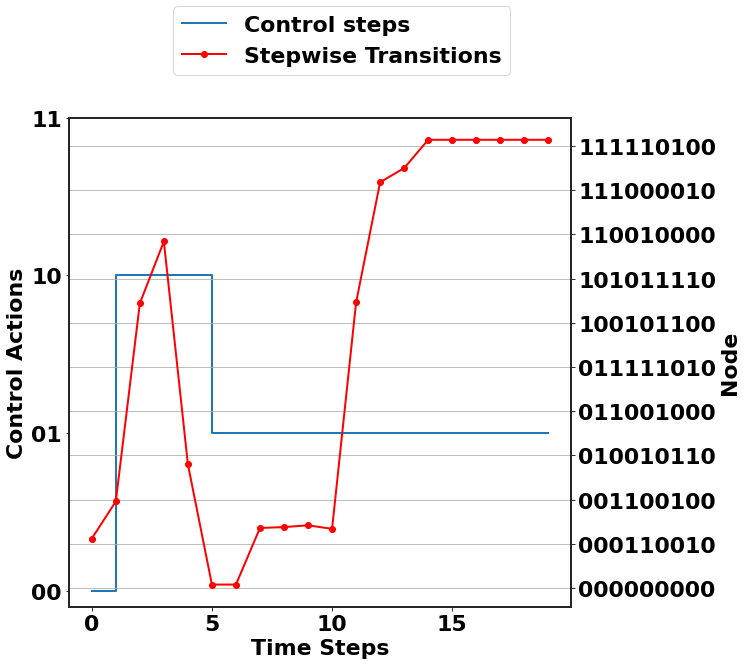

In [16]:
# Visualize the overall steps and actions taken using python plots.
from matplotlib.ticker import StrMethodFormatter

n_test=len(steps)
t=np.linspace(0,n_test-1,n_test)

fig = plt.figure(figsize=(9, 9))
plt.rcParams.update({'font.size': 22, 'font.weight':'bold'})

plt.step(t,steps_actions,label='Control steps',linewidth=2)
plt.yticks(np.arange(0, 4, step=1))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("{x:02b}"))
plt.xlabel('Time Steps',fontweight='bold')
plt.ylabel('Control Actions',fontweight='bold')

ax2=plt.twinx()
ax2.yaxis.set_ticks(np.arange(0, 513, 50))
ax2.plot(t,steps,color='red',linewidth=2, marker='o',label='Stepwise Transitions')
ax2.yaxis.set_major_formatter(StrMethodFormatter("{x:09b}"))
ax2.set_ylabel('Node',fontweight='bold')

handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

plt.legend(handles,labels,loc='upper right',bbox_to_anchor=(0.9, 1.25))
plt.grid()
plt.show()

fig.savefig('steps_9node.png', dpi=300, bbox_inches = "tight")
np.save('steps.npy',steps)
np.save('steps_actions.npy',steps_actions)

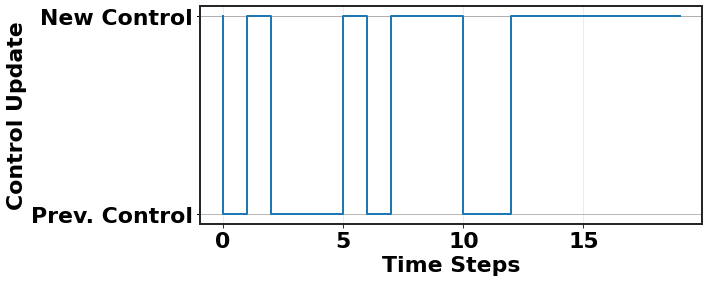

In [23]:
# Visualize the control log to understand when the actions were updated and when they stayed previous actions.

fig = plt.figure(figsize=(9, 4))
plt.rcParams.update({'font.size': 22, 'font.weight':'bold'})

plt.xlabel('Time Steps',fontweight='bold')
plt.ylabel('Control Update',fontweight='bold')

my_xticks = ['New Control','Prev. Control']
plt.yticks(action_flag_log, my_xticks)
plt.step(t,action_flag_log,label='Control steps',linewidth=2)
plt.grid(alpha=0.3)
plt.show()

fig.savefig('control_log_9node.png', dpi=300, bbox_inches = "tight")
np.save('action_flag_log.npy',action_flag_log)